In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize, poly, ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

#  Chapter specifc imports
from pygam import (s as s_gam, f as f_gam, LinearGAM, LogisticGAM, l as l_gam)
from ISLP.transforms import (BSpline, NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam, degrees_of_freedom, plot as plot_gam, anova as anova_gam)   

In [4]:
data = load_data('Wage')
data = data.dropna()
data.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [5]:
y = data['wage']
age = data['age']

In [6]:
# 1. Polynomial regression
poly_age = MS([poly("age", degree=4)]).fit_transform(data)
m = sm.OLS(y, poly_age).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Wed, 02 Apr 2025   Prob (F-statistic):           2.77e-57
Time:                        21:54:49   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                111.7036      0.729    153.283      0.000     110.275     113.132
poly(age, degree=4)[0]   447.0679     39.915     11.201      0.000     368.805     525.331
poly(age, degree=4)[1]  -478.3158     39.915    -11.983      0.000    -556.579    -400.053
poly(age, degree=4)[2]   125.5217     39.915      3.145      0.002      47.259     203.785
poly(age, degree=4)[3]   -77.9112     39.915     -1.952      0.051    -156.174       0.352
==============================================================================
Omnibus:                     1097.594   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4965.521
Skew:                           1.722   Prob(JB):                         0.00
Kurtosis:                       8.279   Cond. No.                         54.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
age_grid = np.linspace(data['age'].min(), data['age'].max(), 1000)
age_df = pd.DataFrame({'age': age_grid})
age_df.head()

,age
0,18.000000
1,18.062062
2,18.124124
3,18.186186
4,18.248248


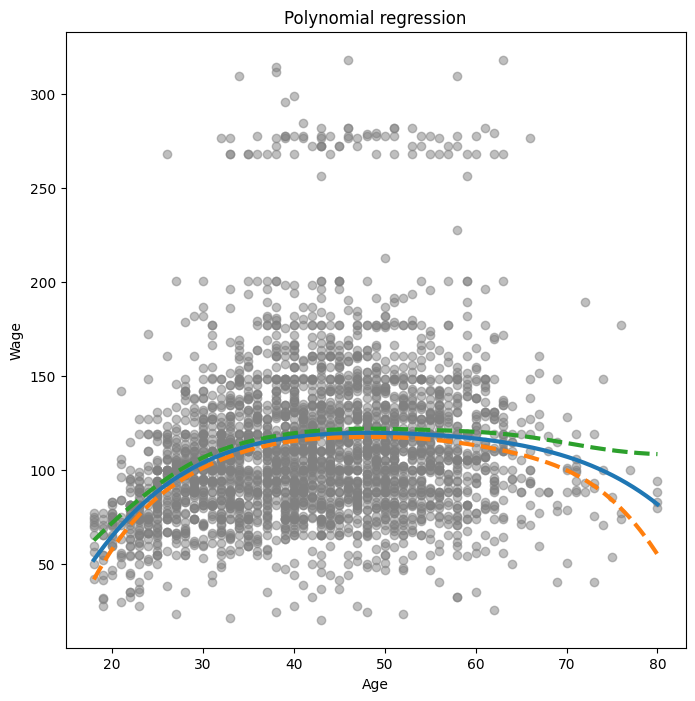

In [8]:
design = MS([poly("age", degree=4)]).fit(data)
x = design.transform(data)
x_new = design.transform(age_df)
model = sm.OLS(y, x).fit()
preds = model.get_prediction(x_new) # This function houses the conf band
bands = preds.conf_int(alpha=0.05) # Gets us the confidence bands
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(age, y, facecolors='gray', alpha = 0.5)
for val, ls in zip([preds.predicted_mean, bands[:,0], bands[:,1]], ['-', '--', '--']):
    ax.plot(age_grid, val, ls = ls, linewidth = 3)
    
# Creates an iterable tuple of predicted_mean & conf_bands
# Conviniently bundles them into a single object
ax.set_title('Polynomial regression')
ax.set_xlabel('Age')
ax.set_ylabel('Wage')
plt.show()


In [9]:
# ANOVA for degree selection
models = [MS([poly("age", degree=i)]).fit(data) for i in range(1, 6)]
x_dat = [m.transform(data) for m in models]
f_test = anova_lm(*[sm.OLS(y, x).fit() for x in x_dat])
f_test

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


Here i am not able to get a sense of the base line used to get _ss-diff_ . 
Okay now i can only look at the decrease of `ssr`. From 0 to 1, there is a decrease in ssr and p_value < 0.05. 

You can see `ss_diff` is 228786, then subsequent is 15755 _( relatively less )_ then adding the third parameter the decrease is 6070.1512 _( relatively less )_

`sm.GLM()` -> Doesn't have any attributes of SSR, Maybe we can use the likelihood

In [10]:
summarize(m).loc[:,"t"] ** 2

# The F values are just the square of the t values
# F_vals = t ** 2

intercept                 23495.678089
poly(age, degree=4)[0]      125.462401
poly(age, degree=4)[1]      143.592289
poly(age, degree=4)[2]        9.891025
poly(age, degree=4)[3]        3.810304
Name: t, dtype: float64

In [11]:
design =  MS([poly("age", degree=4)]).fit(data)
x = design.transform(data)
high_earn = data['wage'] > 250
m = sm.GLM(high_earn, x, family=sm.families.Binomial()).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2995
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -350.61
Date:                Wed, 02 Apr 2025   Deviance:                       701.22
Time:                        21:54:50   Pearson chi2:                 3.70e+03
No. Iterations:                    10   Pseudo R-squ. (CS):           0.009724
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                 -4.3012      0.345    -12.457      0.000      -4.978      -3.624
poly(age, degree=4)[0]    71.9642     26.133      2.754      0.006      20.745     123.183
poly(age, degree=4)[1]   -85.7729     35.929     -2.387      0.017    -156.193     -15.353
poly(age, degree=4)[2]    34.1626     19.697      1.734      0.083      -4.442      72.767
poly(age, degree=4)[3]   -47.4008     24.105     -1.966      0.049     -94.646      -0.156
==========================================================================================
"""

In [12]:
newX = design.transform(age_df)
preds = m.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

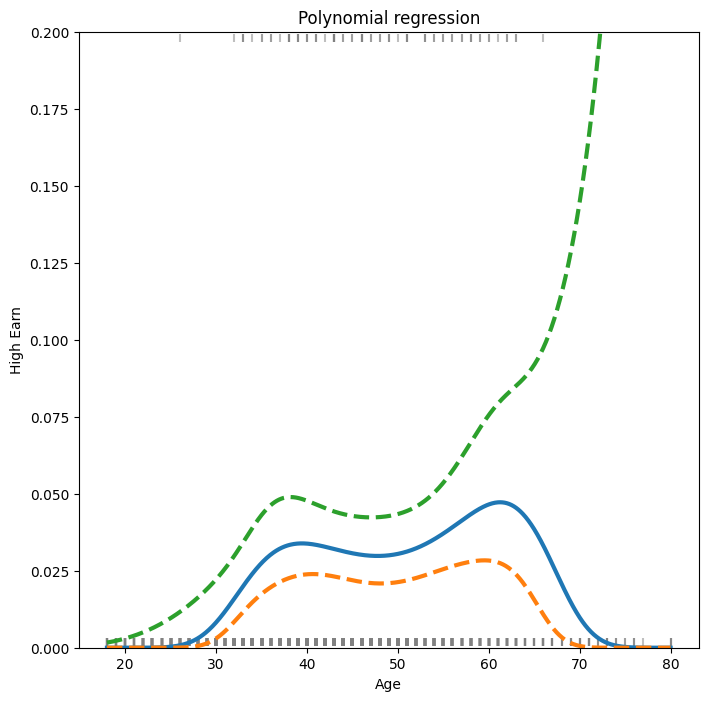

In [13]:
fig, ax = plt.subplots(figsize = (8,8))
rng = np.random.default_rng(0)
# basically we are plotting the high earners as 0.198 due to the y_lim
ax.scatter(age, np.where(high_earn,0.198,0.002), facecolors='gray', alpha = 0.5, marker='|')
for val, ls in zip([preds.predicted_mean, bands[:,0], bands[:,1]], ['-', '--', '--']):
    ax.plot(age_grid, val, ls = ls, linewidth = 3)
ax.set_title('Polynomial regression')
ax.set_xlabel('Age')
ax.set_ylabel('High Earn')
ax.set_ylim([0,0.2])
plt.show()

# This is called a RUG Plot

In [42]:
# Now using the step function
data = load_data('Wage')
data = data.dropna()
age = data['age']
wage = data['wage']

# Step Function : First step towards splines
cut_age = pd.cut(age, 4) # cuts into 4 bins 
cut_age = pd.get_dummies(cut_age) # Classifies which ones are in the bin
model = sm.OLS(y, cut_age).fit()
summarize(model)

,coef,std err,t,P>|t|
"(17.938, 33.5]",94.1584,1.476,63.790,0.0
"(33.5, 49.0]",118.2119,1.081,109.379,0.0
"(49.0, 64.5]",117.8230,1.448,81.351,0.0
"(64.5, 80.0]",101.7990,4.764,21.368,0.0


We can interpret it as people in age group (17.939, 33.5) has an average wage of 94.1584

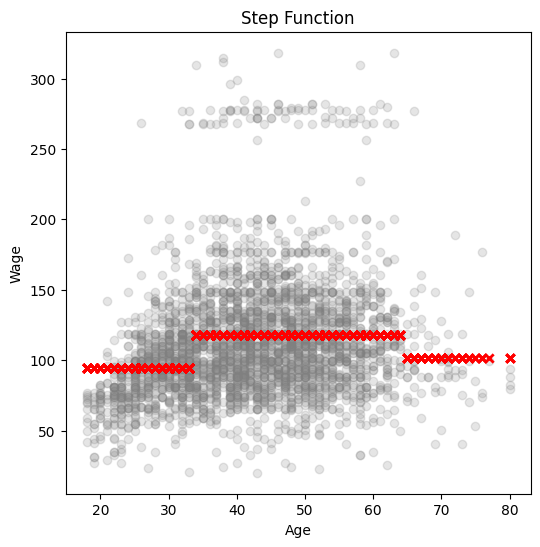

In [15]:
fig, ax = plt.subplots(figsize = (6,6))
ax.scatter(age, wage, facecolors='gray', alpha = 0.2)
ax.scatter(age, model.predict(cut_age), color = 'red', linewidth = 2, marker = 'x')
ax.set_title('Step Function')
ax.set_ylabel('Wage')
ax.set_xlabel('Age')
plt.show()

In [16]:
data = load_data('Wage')
data = data.dropna()
age = data['age']
wage = data['wage']
edu = data['education']
edu = pd.get_dummies(edu)
model = sm.OLS(y, edu).fit()
summarize(model)

,coef,std err,t,P>|t|
1. < HS Grad,84.1044,2.231,37.695,0.0
2. HS Grad,95.7834,1.172,81.715,0.0
3. Some College,107.7556,1.433,75.214,0.0
4. College Grad,124.4279,1.396,89.159,0.0
5. Advanced Degree,150.9178,1.770,85.280,0.0


As Evident, people with higher degree are often higher paid. The Highest Jump being from HS Grad to Some College and College to Advanced Degree.

Process : For category wise predictions 
- `pd.getdummies()` -> for the categories
- `sm.OLS(y, pd.getdummies())` -> for category wise predictions
- Usual plotting of the plots to get a step function

#### Splines

In [17]:
# Transformations for splines
bs_ = BSpline(internal_knots=[25,40,60], intercept=True).fit(age)
bs_age = bs_.transform(age)
bs_age.head()

# Alternative, by default intercept = False
bs_age = MS([bs("age", internal_knots=[25,40,60], name = "bs_age")])
xbs = bs_age.fit_transform(data)
model = sm.OLS(y, xbs).fit()
summarize(model)


,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
bs_age[0],3.9805,12.538,0.317,0.751
bs_age[1],44.6310,9.626,4.636,0.000
bs_age[2],62.8388,10.755,5.843,0.000
bs_age[3],55.9908,10.706,5.230,0.000
bs_age[4],50.6881,14.402,3.520,0.000
bs_age[5],16.6061,19.126,0.868,0.385


In [18]:
# Knots and Df relationship 
bsp = BSpline(df = 6).fit(age)
print(f"Total Df: {bsp.transform(age).shape[1]}")
print(f"Internal Knots: {bsp.internal_knots_}")

# For automatic selection, it chooses the knots based on the quantiles.


Total Df: 6
Internal Knots: [33.75 42.   51.  ]


In [19]:
# Degree and Basis Functions
# With Degree = 0, it fits the data with a constant function.
bs_age = MS([bs("age", degree=0, df=3, name = "bs_age")]).fit(data)
xbs = bs_age.transform(data)
model_wo_ = sm.OLS(y, xbs).fit()


# Implementing with qcut
cut = pd.qcut(age, 4)
cutnoi = pd.get_dummies(cut)
model = sm.OLS(y, cutnoi).fit()

print(f"Summary of the model with qcut: \n {summarize(model)}")
print(f"Summary of model wo qcut : \n {summarize(model_wo_)}")


Summary of the model with qcut: 
                      coef  std err       t  P>|t|
(17.999, 33.75]   94.1584    1.478  63.692    0.0
(33.75, 42.0]    116.6608    1.470  79.385    0.0
(42.0, 51.0]     119.1887    1.416  84.147    0.0
(51.0, 80.0]     116.5717    1.559  74.751    0.0
Summary of model wo qcut : 
               coef  std err       t  P>|t|
intercept  94.1584    1.478  63.687    0.0
bs_age[0]  22.3490    2.152  10.388    0.0
bs_age[1]  24.8076    2.044  12.137    0.0
bs_age[2]  22.7814    2.087  10.917    0.0


Why is the sum not the same ? 
- `qcut()` uses <= while `bs()` uses < , so there might be some difference while fitting but it should be negligible.

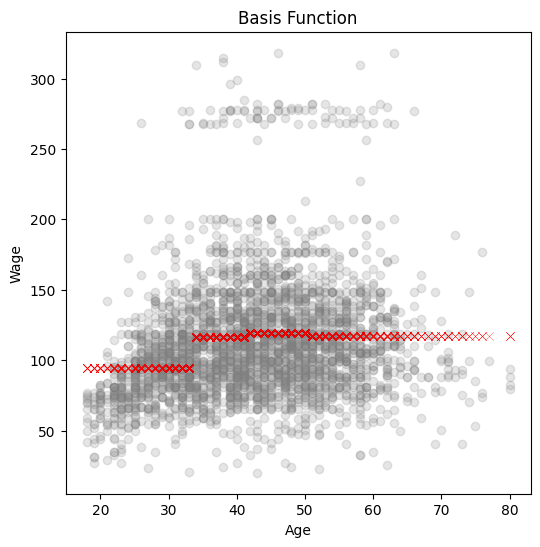

In [20]:
# With Degree = 0, it got us the step function.
fig, ax = plt.subplots(figsize = (6,6))
ax.scatter(age, wage, facecolors='gray', alpha = 0.2)
ax.scatter(age, model_wo_.predict(xbs), color = 'red', linewidth = 0.2, marker='x')
ax.set_title('Basis Function')
ax.set_ylabel('Wage')
ax.set_xlabel('Age')
plt.show()

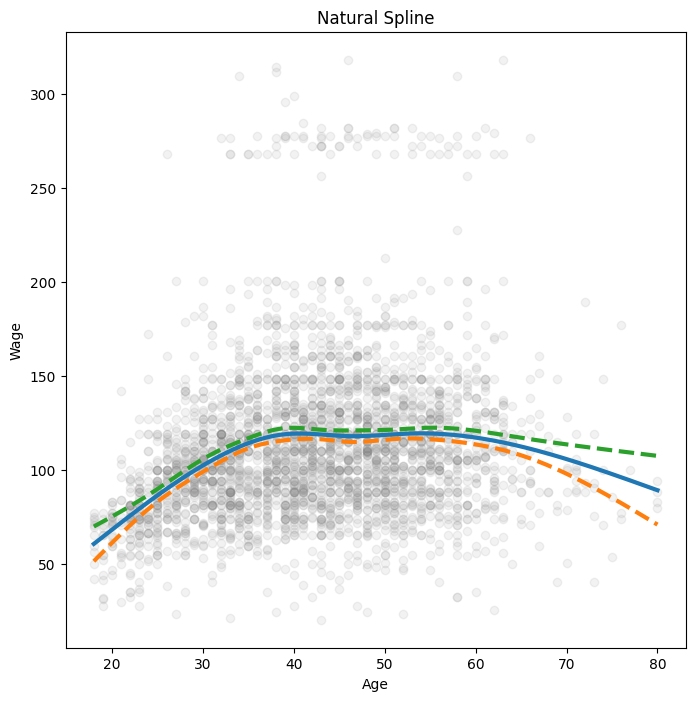

In [21]:
# Natural Splines
ns_age = MS([ns("age", df=5, name = "ns_age")]).fit(data)
xns = ns_age.transform(data)
model = sm.OLS(y, xns).fit()
summarize(model)

# plot the natural spline
x_new = ns_age.transform(age_df)
preds = model.get_prediction(x_new)
bands = preds.conf_int(alpha=0.05)

fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(age, wage, facecolors='gray', alpha = 0.1)
for vals, ls in zip([preds.predicted_mean, bands[:,0], bands[:,1]], ['-', '--', '--']):
    ax.plot(age_grid, vals, ls = ls, linewidth = 3)
ax.set_title('Natural Spline')
ax.set_ylabel('Wage')
ax.set_xlabel('Age')
plt.show()

In [22]:
data = load_data("Wage")
age = data.loc[:, "age"]
y = data.loc[:, "wage"]

In [23]:
# We need to reshape as the model expects a 2D array
x_age = np.asarray(age).reshape(-1,1) # -1 = total elements / 1 -> basically a column vector
gam = LinearGAM(s_gam(0, lam=0.6)) # s_gam is a smooth function to be applied to the first column
gam.fit(x_age, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
/var/folders/h3/pvdfbwyx1txcx5ftyxsw_chr0000gn/T/ipykernel_49405/1946825236.py:17: SyntaxWarning: invalid escape sequence '\l'
  ax.legend(title = "$\lambda$")
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


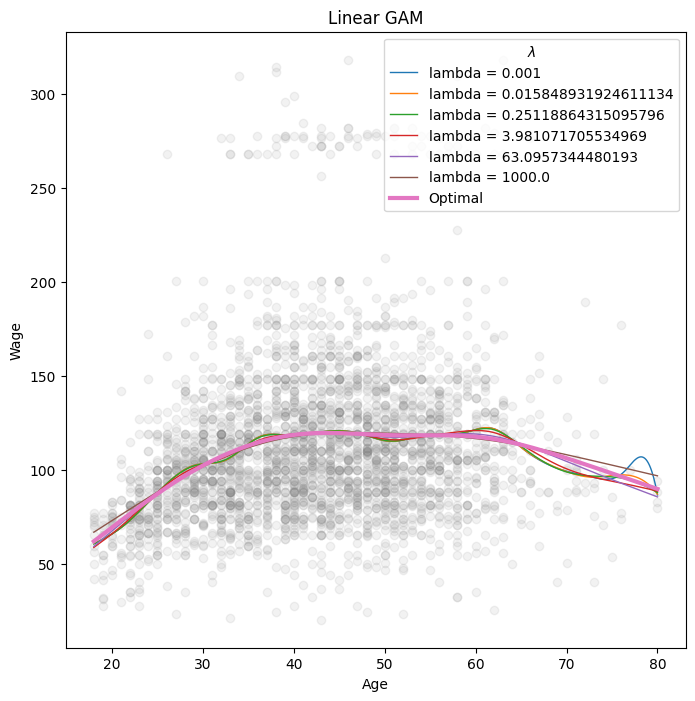

In [24]:
# Effect of penalization
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(age, y, facecolors='gray', alpha = 0.1)
for lam in np.logspace(-3, 3, 6):
    gam = LinearGAM(s_gam(0, lam=lam)).fit(x_age, y)
    ax.plot(age_grid, 
            gam.predict(age_grid), 
            label = f"lambda = {lam}", 
            linewidth = 1)
ax.set_title('Linear GAM')
ax.set_ylabel('Wage')
ax.set_xlabel('Age')

# Searching for the optimal penalization
gam_opt = gam.gridsearch(x_age, y)
ax.plot(age_grid, gam_opt.predict(age_grid), label = "Optimal", linewidth = 3)
ax.legend(title = "$\lambda$")
plt.show()

In [25]:
# Alternative : Find the $\lambda$ that gives df = 4
age_ = gam.terms[0]
lam_4 = approx_lam(x_age, age_, 4)
age_.lam = lam_4
degrees_of_freedom(x_age, age_)

4.000000100001664

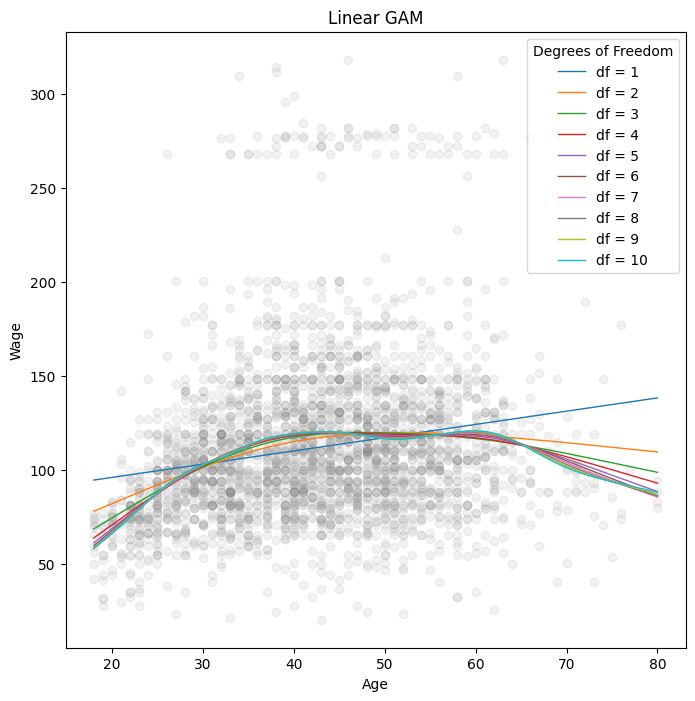

In [26]:
# Effect of varying Degrees of Freedom and using it to get LAM
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(age, y, facecolors='gray', alpha = 0.1)
for df in range(1, 11):
    lam = approx_lam(x_age, age_, df+1)
    gam = LinearGAM(s_gam(0, lam=lam)).fit(x_age, y)
    gam.fit(x_age, y)
    ax.plot(age_grid, 
            gam.predict(age_grid), 
            label = f"df = {df}", 
            linewidth = 1)
ax.set_title('Linear GAM')
ax.set_ylabel('Wage')
ax.set_xlabel('Age')
ax.legend(title = "Degrees of Freedom")
plt.show()

As we can see with penalization is less i.e. $\lambda \approx 0$ the curve is more wigglier as expected we are just fitting the smoothing function, but as the penalization $\lambda$ increases we are seeing a straight line because the smooth terms are penalized

In [27]:
# Additive models with several terms
# 1. Natural splines with piecewise constant function
# 2. Using pygam package and smoothing splines. 

ns_age = NaturalSpline(df = 4).fit(age)
ns_year = NaturalSpline(df = 5).fit(data['year'])
Xs = [ns_age.transform(age), ns_year.transform(data['year']), pd.get_dummies(data['education']).values]
noi = np.column_stack(Xs) # Stack the columns
model = sm.OLS(y, noi).fit()
summarize(model)

,coef,std err,t,P>|t|
x1,46.4460,3.732,12.446,0.000
x2,28.9349,3.884,7.449,0.000
x3,63.6722,9.231,6.898,0.000
x4,10.9669,7.650,1.434,0.152
x5,1.8374,3.177,0.578,0.563
x6,10.4409,3.790,2.755,0.006
x7,2.0020,3.399,0.589,0.556
x8,9.6055,4.053,2.370,0.018
x9,5.8989,2.419,2.438,0.015
x10,43.8013,4.383,9.993,0.000


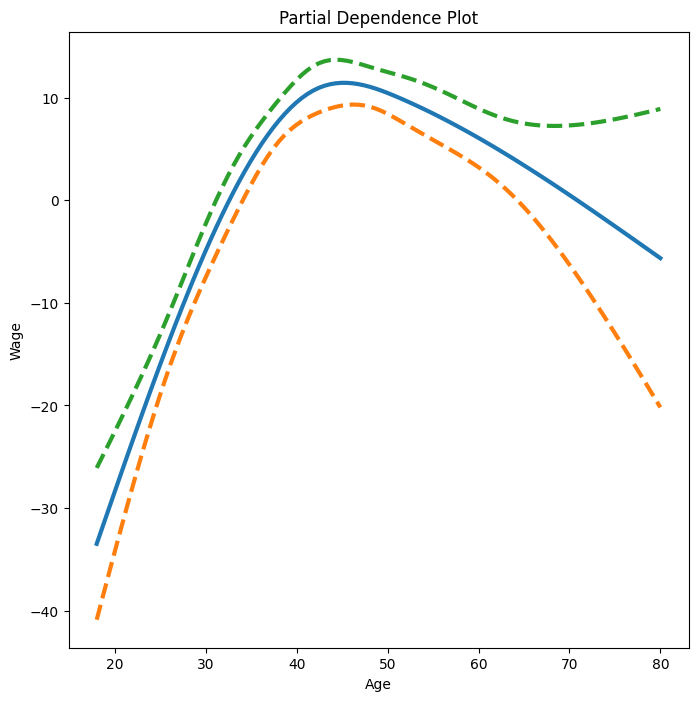

In [28]:
# Partial dependence plots 
# New Matrix -> Fixing all but one features at a time. 

age_grid = np.linspace(age.min(), age.max(), 100)
x_age = noi.copy()[:100]
x_age[:] = noi[:].mean(0).reshape(1,-1) # Single row containing the means of every feature
x_age[:, :4] = ns_age.transform(age_grid) # Just changing the xage values
preds = model.get_prediction(x_age)
bounds_age = preds.conf_int(alpha=0.05)
partial_age = preds.predicted_mean

# to get the relative effect of centering.
center = partial_age.mean()
partial_age -= center
bounds_age -= center

# Plotting the partial dependence plot
fig, ax = plt.subplots(figsize = (8,8))
for val, ls in zip([partial_age, bounds_age[:,0], bounds_age[:,1]], ['-', '--', '--']):
    ax.plot(age_grid, val, ls = ls, linewidth = 3)
ax.set_title('Partial Dependence Plot')
ax.set_ylabel('Wage')
ax.set_xlabel('Age')    
plt.show()


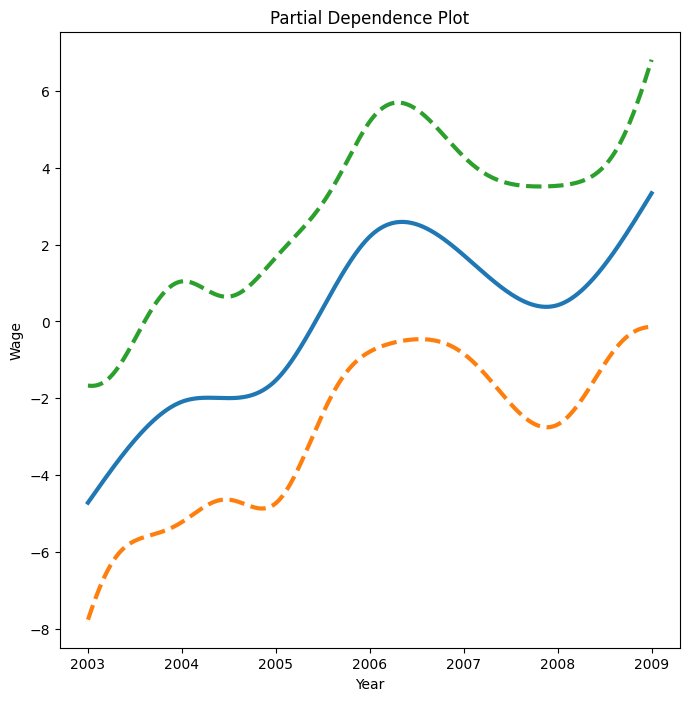

In [29]:
# Partial Year plot
year = data["year"]
year_des = np.linspace(year.min(), year.max(), 1000)
x_year = noi.copy()[:1000]
x_year[:] = noi[:].mean(0).reshape(1,-1) # Replace it with the means -> Averaging
x_year[:, 4:9] = ns_year.transform(year_des)
preds = model.get_prediction(x_year)
partial_year = preds.predicted_mean
bounds_year = preds.conf_int(alpha=0.05)

# Centering
center = partial_year.mean()
partial_year -= center
bounds_year -= center

# Plotting
fig, ax = plt.subplots(figsize = (8,8))
for val, ls in zip([partial_year, bounds_year[:,0], bounds_year[:,1]], ['-', '--', '--']):
    ax.plot(year_des, val, ls = ls, linewidth = 3)
ax.set_title('Partial Dependence Plot')
ax.set_ylabel('Wage')
ax.set_xlabel('Year')
plt.show()

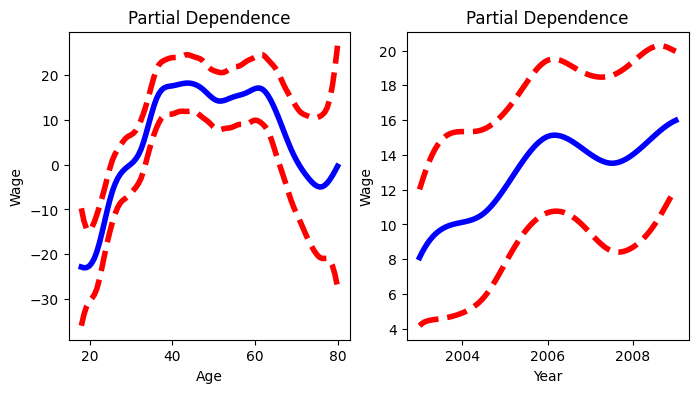

In [30]:
# Automated fashion
# f_gam(2, lam = 0) -> f_gam is a smooth function to be applied to the third column with zero penalty
# s_gam(1, n_splines=7) -> s_gam is a smooth function to be applied to the second column with 7 splines
# s_gam(0) -> s_gam is a smooth function to be applied to the first column with default penalty value = 0.6
gam = LinearGAM(s_gam(0,) + s_gam(1, n_splines=7) + f_gam(2, lam = 0))
edu = data["education"].cat.codes
xs = np.column_stack([age,data.loc[:,"year"], edu])
gam_fit = gam.fit(xs, y)

# Plotting
fig, ax = plt.subplots(1,2, figsize = (8,4))
plot_gam(gam_fit,0, ax = ax[0])
plot_gam(gam_fit,1, ax = ax[1])
ax[0].set_title('Partial Dependence')
ax[0].set_ylabel('Wage')
ax[0].set_xlabel('Age')

ax[1].set_title('Partial Dependence')
ax[1].set_ylabel('Wage')
ax[1].set_xlabel('Year')
plt.show()

# Curve is abit wigglier


In [31]:
age_term = gam.terms[0]
year_term = gam.terms[1]
age_term.lam = approx_lam(xs, age_term, 4)
year_term.lam = approx_lam(xs, year_term, 5)
gam_fit = gam.fit(xs, y)

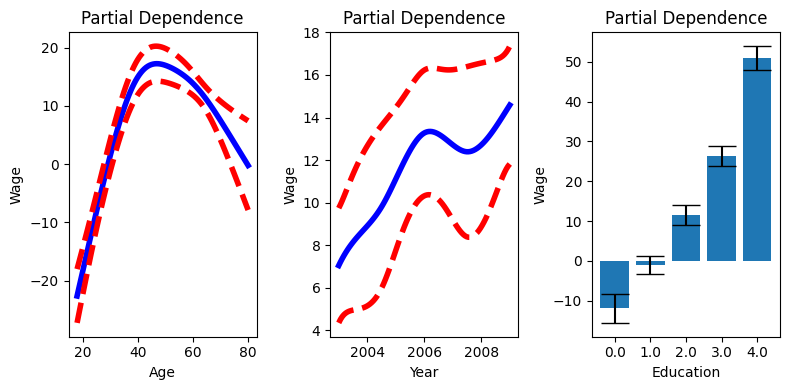

In [32]:
# Plotting
fig, ax = plt.subplots(1,3, figsize = (8,4))
plot_gam(gam_fit,0, ax = ax[0])
plot_gam(gam_fit,1, ax = ax[1])
plot_gam(gam_fit, 2, ax = ax[2])
ax[0].set_title('Partial Dependence')
ax[0].set_ylabel('Wage')
ax[0].set_xlabel('Age')
ax[1].set_title('Partial Dependence')
ax[1].set_ylabel('Wage')
ax[1].set_xlabel('Year')
ax[2].set_title('Partial Dependence')
ax[2].set_ylabel('Wage')
ax[2].set_xlabel('Education')
plt.tight_layout()
plt.show()

# Now they are less wiggly

Very interesting right to get the partial dependence. 
- Your wage peaks around the age of 40-50 and drops off 
- With year you expect your wage to rise
- With education your wage rises the highest

In [33]:
# Anova Tests : Which model is better.
# M1 = gam that excludes year vs M2 = gam that uses year vs M3 = gam that uses a spline
m = LinearGAM(age_term + f_gam(2, lam = 0))
m_linear = LinearGAM(age_term + l_gam(1, lam = 0) + f_gam(2, lam = 0))
m_spline = LinearGAM(age_term + year_term + f_gam(2, lam = 0))
m.fit(xs, y)
m_linear.fit(xs, y)
m_spline.fit(xs, y)

# Anova Test
anova_gam(m, m_linear, m_spline)

# Drop in deviance is significant for linear model

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.719329e+06,2992.003779,NaN,NaN,NaN,NaN
1,3.702069e+06,2991.004661,17260.194424,0.999118,13.956601,0.002850
2,3.698545e+06,2988.006566,3524.120230,2.998095,0.949633,0.447497


Ahh fq the wage growth with age is linear. Sheesh, not getting into jobs again

In [34]:
m_spline.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     11.9934
Link Function:                     IdentityLink Log Likelihood:                                -24121.2871
Number of Samples:                         3000 AIC:                                            48268.5611
                                                AICc:                                           48268.6829
                                                GCV:                                             1246.7652
                                                Scale:                                           1237.7966
                                                Pseudo R-Squared:                                   0.2917
Feature Function                  Lam

/var/folders/h3/pvdfbwyx1txcx5ftyxsw_chr0000gn/T/ipykernel_49405/2675287991.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  m_spline.summary()


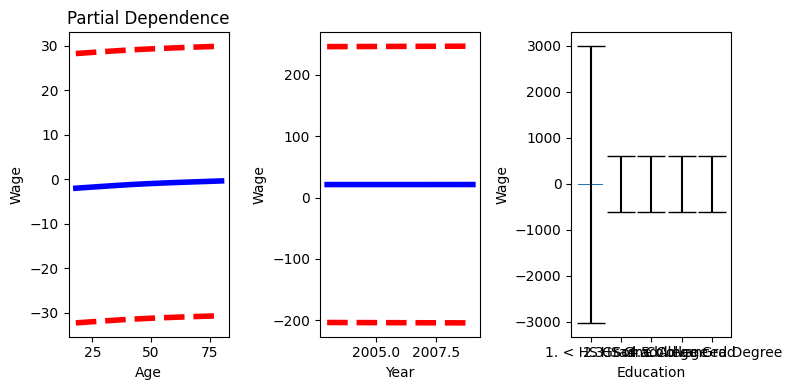

In [35]:
# Some terms
yhat = gam_fit.predict(xs)

gam_logit = LogisticGAM(age_term + l_gam(1, lam = 0) + f_gam(2, lam = 0))
gam_logit.fit(xs, y > 250)

fig, ax = plt.subplots(1,3, figsize = (8,4))
plot_gam(gam_logit, 0, ax = ax[0])
plot_gam(gam_logit, 1, ax = ax[1])
plot_gam(gam_logit, 2, ax = ax[2])
ax[0].set_title('Partial Dependence')
ax[0].set_xlabel('Age')
ax[1].set_xlabel('Year')
ax[2].set_xlabel('Education')
ax[2].set_xticklabels(data['education'].cat.categories)
[ax[i].set_ylabel('Wage') for i in range(3)]
plt.tight_layout()
plt.show()

# Very flat model with high error rates

In [36]:
data_noi = data.copy()
data_noi.loc[:, "high_earn"] = data_noi["wage"] > 250
pd.crosstab(data_noi["high_earn"], data_noi["education"])

# There are no high earners in the first category of education. 
# So how can a supervised model fit this well ? No

education,1. < HS Grad,2. HS Grad,3. Some College,4. College Grad,5. Advanced Degree
high_earn,,,,,
False,268,966,643,663,381
True,0,5,7,22,45


In [37]:
# Fitting without the first category
only_hs = data_noi["education"] != "1. < HS Grad"
data_ = data_noi.loc[only_hs]
edu = data_["education"].cat.codes-1
xs = np.column_stack([data_["age"], data_["year"], edu])
gam_logit_ = LogisticGAM(age_term + year_term + f_gam(2, lam = 0))
gam_logit_.fit(xs, data_["high_earn"])

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + intercept, tol=0.0001, verbose=False)

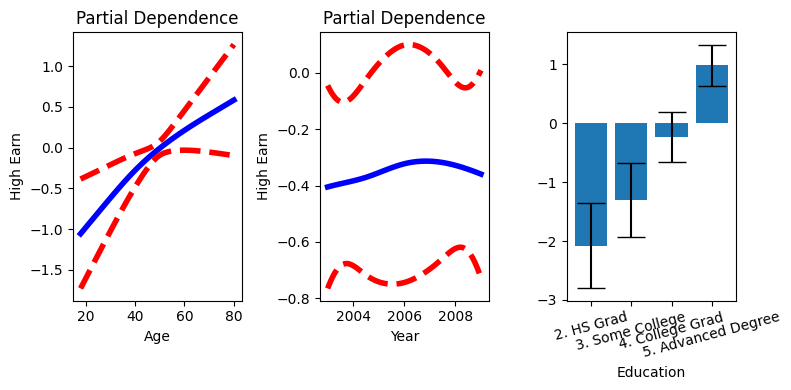

In [38]:
fig, ax = plt.subplots(1,3,figsize = (8,4))
plot_gam(gam_logit_, 0, ax = ax[0])
plot_gam(gam_logit_, 1, ax = ax[1])
plot_gam(gam_logit_, 2, ax = ax[2])
[ax[i].set_title('Partial Dependence') for i in range(2)]
[ax[i].set_ylabel('High Earn') for i in range(2)]
ax[0].set_xlabel('Age')
ax[1].set_xlabel('Year')
ax[2].set_xticklabels(data_['education'].cat.categories[1:])
ax[2].xaxis.set_tick_params(rotation=15)
ax[2].set_xlabel('Education')

plt.tight_layout()
plt.show()

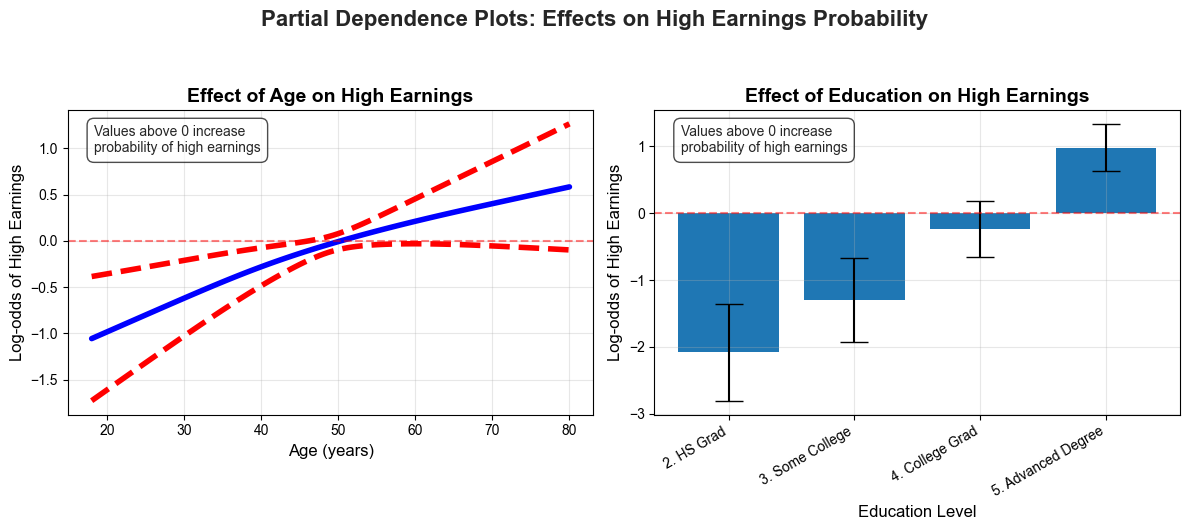

In [39]:
# Create a more refined visualization of GAM partial dependencies
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Set a clean, modern style
plt.style.use('seaborn-v0_8-whitegrid')

# Plot Age partial dependence
plot_gam(gam_logit_, 0, ax=ax[0])
ax[0].set_title('Effect of Age on High Earnings', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Log-odds of High Earnings', fontsize=12)
ax[0].set_xlabel('Age (years)', fontsize=12)
ax[0].grid(alpha=0.3)



# Plot Education partial dependence
plot_gam(gam_logit_, 2, ax=ax[1])
ax[1].set_title('Effect of Education on High Earnings', fontsize=14, fontweight='bold')
ax[1].set_ylabel('Log-odds of High Earnings', fontsize=12)

# Get education categories and format them properly
categories = data_['education'].cat.categories.tolist()
# Remove the first category as it's the reference level (if that's how your model is set up)
formatted_categories = categories[1:] if len(categories) > 1 else categories

# Set x-ticks and labels for education
ax[1].set_xticks(range(len(formatted_categories)))
ax[1].set_xticklabels(formatted_categories, rotation=30, ha='right', fontsize=10)
ax[1].set_xlabel('Education Level', fontsize=12)
ax[1].grid(alpha=0.3)

# Add reference line at y=0 for both plots
ax[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Add annotations explaining the plots
ax[0].annotate('Values above 0 increase\nprobability of high earnings', 
               xy=(0.05, 0.95), xycoords='axes fraction', 
               fontsize=10, ha='left', va='top',
               bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))

ax[1].annotate('Values above 0 increase\nprobability of high earnings', 
               xy=(0.05, 0.95), xycoords='axes fraction', 
               fontsize=10, ha='left', va='top',
               bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))

# Add a title for the entire figure
fig.suptitle('Partial Dependence Plots: Effects on High Earnings Probability', 
             fontsize=16, fontweight='bold', y=1.05)

# Adjust layout and spacing
fig.tight_layout()
plt.subplots_adjust(top=0.85)

# Show the plot
plt.show()

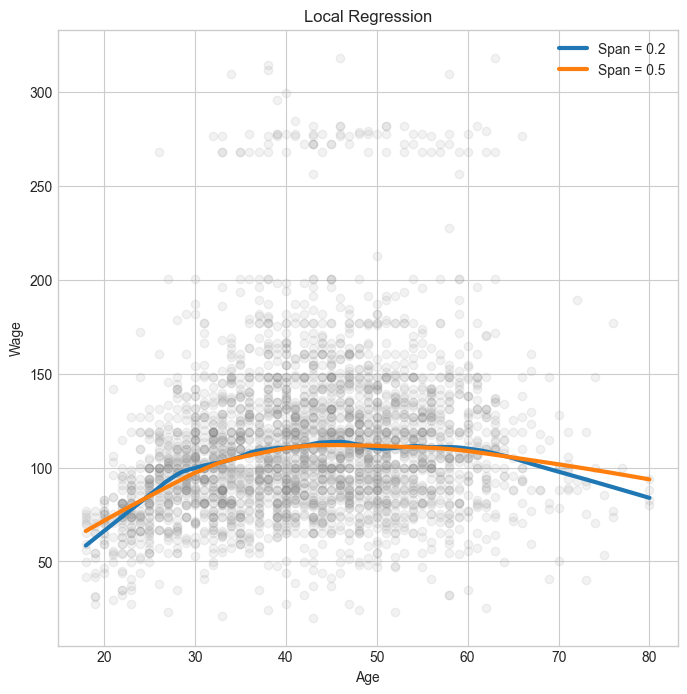

In [40]:
# Using local regression
local_reg = sm.nonparametric.lowess

fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(age, wage, facecolors='gray', alpha = 0.1)
for span in [0.2, 0.5] : # Contains 20% & 50% of the data
    fitted = local_reg(wage, age, frac = span, xvals=age_grid)
    ax.plot(age_grid, fitted, label = f"Span = {span}", linewidth = 3)
ax.set_title('Local Regression')
ax.set_ylabel('Wage')
ax.set_xlabel('Age')
plt.legend()
plt.show()


### Functions Used 
- `MS([poly("var", degree = i)])` : To fit a polynomial with degree _i_
  - Actual splines are in scipy.interpolate

`poly()` is different, underlying it uses `PCA()`
- `model.get_predictions()` : Builds a function that can get you the _conf-int_ & _preds.predicted_mean_, using that you can simply plot the model and its conf interval
- `zip()` : takes in multiple lists and tuples and joins them to get one iterator which can be iterated conviniently upon
- "*" is pythons unpacking operator
- `pd.cut()` : cut the variables into different sections
- `pd.qcut()` : cut the variables into with the _quantiles_
- `pd.get_dummies()` : gets us true and false values for the dummies -> so that different models can be fit.
- `MS([bs(<col>, internal_knots = [])])` : For transforming the variables in the spline knot.
- `MS([ns('age', df=5)]).fit()` : For transforming the variables to natural splines. 
- `pygam` is the python library for fitting Generalized Additive Models
- `LinearGAM()` : Uses a squared error loss. `s` for smoothing, `l` for linear, `f` for factor or categorical variables. `lam` is the $\lambda$ for penalization   
  - `gam.gridsearch()` : Searches for the optimal level of penalization. Probably implements CV on the inside but highly optimized
  - `approx_lam(<cols>, df)` : Gives us the approx penalization for the appropriate degree of freedom specified. Underlying probably uses the formula for degree of freedom and calculates $\lambda$ from it 
- `NaturalSplines()` with the `transform()` function to get the natural splines values. 
- To construct the partial dependence plots 
  - First put everything to constant (average) except the partial columns of the variable
  - Get predictions and bounds and center those. 
  - Problem with mannual fashion is that you have to be very clear with what you are doing, like here _understanding_ the column names is difficult
- `gam()` likes to work with matrices so be aware about it
- `sm.nonparametric.lowess` : contains the local regression

#### Tasks & Questions : 
- Code these from scratch
- More clarity in splines and knots <-> degree of freedom ✅
- `df = 0` : Why does it fit stepwise function ? mathematical notations ahh 1 right ? ✅
- What are natural splines : Learn more about them
- Why smoothing spline is a special case of GAM with squared error loss ?
- What does penalization penalize actually? ✅
- Need clariy in what does `hstack`, `vstack`, `rowstack` & `columnstack` does and what is the difference
- Need more reading on local regression

